A CNN on the global views 500x500

In [1]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from helpers.data_loading import *
from helpers.CNN_layers import ConvLayer, DenseLayer
from spearman import score_function

In [2]:
y, _ = load_labels()  # scores between 0 and 25 for training instances
y = y.reshape((-1,1))

In [56]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement=True
sess = tf.InteractiveSession(config=config)

input_tf = tf.placeholder(tf.float32, shape=[None, 100, 100, 3])
y_tf = tf.placeholder(tf.float32, shape=[None, 1])

conv1 = ConvLayer(input_tf, 16)
conv1.max_pool()

conv2 = ConvLayer(conv1.output, 32)
conv2.max_pool()

conv3 = ConvLayer(conv2.output, 64)
conv3.max_pool()

fc1 = DenseLayer(conv3.output, 100)
fc1.drop_out()

fc2 = DenseLayer(fc1.output, 1)

# final_output = 24. * (1 / (1 + tf.exp(- fc2.output)))  # logit to normalize
final_output = fc2.output

In [64]:
mse = (
    tf.reduce_mean((final_output - y_tf)**2) + 0.1*(
        tf.nn.l2_loss(conv1.W) +
        tf.nn.l2_loss(conv2.W) +
        tf.nn.l2_loss(conv3.W) +
        tf.nn.l2_loss(fc1.W) +
        tf.nn.l2_loss(fc2.W) 
    )
)
learning_rate = tf.placeholder(tf.float32, shape=[])
train_step = tf.train.AdamOptimizer(learning_rate).minimize(mse)

In [65]:
sess.run(tf.global_variables_initializer())

In [66]:
mse.eval(feed_dict={
    input_tf: faces_batch(np.arange(1, 51), black_white=False)[0], 
    y_tf: y[0:50,:], 
    fc1.keep_prob: 1.0
})

117070.88

In [67]:
type(local_views_batch(np.arange(1, 11))[0][0,0,0])

numpy.float32

In [68]:
# WARNING indices for y and when calling global_views_batch differ from 1
# we create a quick batch generator for the training and the testing

# sample train/test indices # WARNING indexed from 1!!!
train = np.random.choice(range(1, 10**4), size = 9500, replace = False)
test = np.setdiff1d(np.arange(1, 10**4), train)

def train_batch(batch_size=50, black_white=True, random_flip=False):
    nb_batch = len(train) // batch_size
    while 1:
        for i in range(nb_batch):
            in_batch = train[i*batch_size:((i+1)*batch_size)]
            X_batch, _ = faces_batch(in_batch, black_white=black_white)
            y_batch = y[in_batch-1]  # WARNING Y is indexed from 0!!!
            y_batch = y_batch.astype(np.float32)
            if random_flip and np.random.rand() > 0.5:
                # with proba 0.5 we flip the face
                X_batch = X_batch[:, :, ::-1, :]
            yield X_batch/255., y_batch
            
def test_batch(batch_size=50, black_white=True):
    nb_batch = len(test) // batch_size
    while 1:
        for i in range(nb_batch):
            in_batch = test[i*batch_size:((i+1)*batch_size)]
            X_batch, _ = faces_batch(in_batch, black_white=black_white)
            y_batch = y[in_batch-1]  # WARNING Y is indexed from 0!!!
            y_batch = y_batch.astype(np.float32)
            yield X_batch/255., y_batch

In [69]:
train_gen = train_batch(100, black_white=False, random_flip=True)
test_gen = test_batch(300, black_white=False)

In [70]:
X_test, y_test = next(test_gen)
#X_test = X_test.reshape((-1, 200, 200, 1))
print X_test.shape
print y_test.shape

(300, 100, 100, 3)
(300, 1)


In [75]:
def epoch(lr=1e-4):
    X_train, y_train = next(train_gen)
    #X_train = X_train.reshape((-1, 200, 200, 1))
    # X_test, y_test = next(test_gen)
    # X_test = X_test.reshape((-1, 200, 200, 1))
    train_step.run(feed_dict={
        input_tf: X_train, 
        y_tf: y_train,
        fc1.keep_prob: 1.,
        learning_rate: lr
    })
    train_mse = sess.run(mse, feed_dict={input_tf:X_train, y_tf: y_train, fc1.keep_prob: 1.0})
    
    # preds on test
    preds = final_output.eval(feed_dict={input_tf: X_test, fc1.keep_prob: 1.0})
    #print preds.flatten()[0:10]
    test_mse = np.mean((preds - y_test)**2)
    current_spearman = score_function(y_pred=np.round(preds), y_true=y_test)
    
    return {"train_mse":train_mse, "test_mse":test_mse, "test_spearman":current_spearman, 'lr': lr}

In [76]:
learning_history = {'iterations':[], 'train_mse':[], 'test_mse':[], 'test_spearman':[], 'lr':[]}

def update_history(learning_history, epoch):
    learning_history['iterations'].append(len(learning_history['iterations']))
    for name in ['train_mse', 'test_mse', 'test_spearman', 'lr']:
        learning_history[name].append(epoch[name])

i=9999


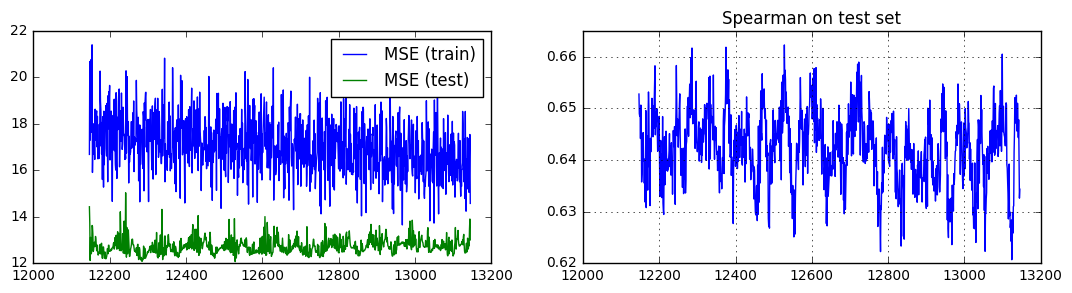

In [80]:
window = 1000  # plot only last x iterations
refresh = 20  # refresh every x iterations
for i in range(10000):
    update_history(learning_history, epoch(lr=10**-4))
    if (i+1) % refresh == 0:
        clear_output()
        print "i=%i"%i
        f, axarr = plt.subplots(1, 2, figsize=(13, 3))
        axarr[0].plot(learning_history['iterations'][:-window:-1][::-1], learning_history['train_mse'][:-window:-1][::-1], label="MSE (train)")
        axarr[0].plot(learning_history['iterations'][:-window:-1][::-1], learning_history['test_mse'][:-window:-1][::-1], label="MSE (test)")
        axarr[1].plot(learning_history['iterations'][:-window:-1][::-1], learning_history['test_spearman'][:-window:-1][::-1], label="Spearman (test)")
        axarr[0].legend()
        axarr[1].set_title("Spearman on test set")
        axarr[1].grid()
        plt.show()

i=9999


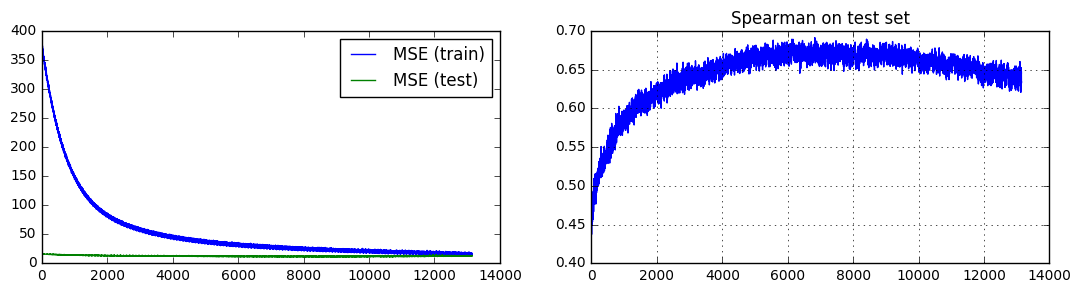

In [82]:
clear_output()
print "i=%i"%i
f, axarr = plt.subplots(1, 2, figsize=(13, 3))
axarr[0].plot(learning_history['iterations'], learning_history['train_mse'], label="MSE (train)")
axarr[0].plot(learning_history['iterations'], learning_history['test_mse'], label="MSE (test)")
axarr[1].plot(learning_history['iterations'], learning_history['test_spearman'], label="Spearman (test)")
axarr[0].legend()
axarr[1].set_title("Spearman on test set")
axarr[1].grid()
plt.show()

In [85]:
# get Test spearman on all test set
X_all_test, y_all_test = next(test_batch(len(test), black_white=False))
preds = final_output.eval(feed_dict={input_tf: X_all_test, fc1.keep_prob: 1.0})
print score_function(y_pred=np.round(preds), y_true=y_all_test)

0.610886413263


In [94]:
# make a quick submission
X_to_predict, ids_to_predict = faces_batch(np.arange(10001, 13001), black_white=False)
X_to_predict = X_to_predict/255.
final_predictions = np.array([])
for i in range(0, 30):
    print i
    final_predictions = np.append(final_predictions, 
              final_output.eval(feed_dict={input_tf: X_to_predict[(i*100):((i+1)*100)], fc1.keep_prob: 1.0}).flatten()
    )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [105]:
export_submission(np.round(final_predictions), name='CNN_faces_L2reg')